In [4]:
from keras.datasets import mnist
from sklearn.utils import shuffle
from models.VLAE import VLAE

vlae = VLAE(input_dim=(28, 28, 1), log_dir="", kernel_visualization_layer=1, num_samples=1, feature_map_layers=[1], inner_activation="ReLU", decay_rate=0, feature_map_reduction_factor=1, z_dims=[2,2,2])
vlae.load_weights("/Users/leo/Downloads/vlae.h5")

Using TensorFlow backend.


In [5]:
from models.VAE import VariationalAutoencoder

vae = VariationalAutoencoder(input_dim=(128,128,1),encoder_conv_filters=[32, 64, 64, 64],encoder_conv_kernel_size=[3, 3, 3, 3], encoder_conv_strides=[2, 2, 2, 2],decoder_conv_t_filters=[64, 64, 32, 1],decoder_conv_t_kernel_size=[3, 3, 3, 3],decoder_conv_t_strides=[2, 2, 2, 2],z_dims=[2], log_dir="", feature_map_layers=[], kernel_visualization_layer=1, dropout_rate=0.3, use_batch_norm=True, use_dropout=True)
vae.load_weights("/Users/leo/Downloads/vanilla_vae.h5")

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [67]:
import numpy as np
import scipy as sp
from utils.img_ops import resize_array
(_,_),(mnists,_) = mnist.load_data()
mnists = shuffle(mnists)
mnists = mnists.reshape((mnists.shape[0], -1))
mnist_mean = np.mean(mnists, axis=1)
mnist_sd = np.std(mnists, axis=1)
mnist_skew = sp.stats.skew(mnists, axis=1)
mnist_kurt = sp.stats.kurtosis(mnists, axis=1)

vlae_gens = vlae.decoder.predict([np.random.multivariate_normal([0.,0.], [[1.0, 0.0],[0.0, 1.0]], size=10000) for _ in range(3)]).squeeze()
vlae_gens = np.stack(vlae_gens)
vlae_gens *= 255.0
vlae_gens = vlae_gens.reshape(vlae_gens.shape[0], -1)
vlae_gens_mean = np.mean(vlae_gens, axis=1)
vlae_gens_sd = np.std(vlae_gens, axis=1)
vlae_gens_skew = sp.stats.skew(vlae_gens, axis=1)
vlae_gens_kurt = sp.stats.kurtosis(vlae_gens, axis=1)

vae_gens = vae.decoder.predict(np.random.multivariate_normal([0.,0.], [[1.0, 0.0],[0.0, 1.0]], size=10000))
vae_gens = np.stack(vae_gens)
vae_gens *= 255.0
vae_gens = resize_array(vae_gens, (28,28), False)
vae_gens = vae_gens.reshape(vae_gens.shape[0], -1)
vae_gens_mean = np.mean(vae_gens, axis=1)
vae_gens_sd = np.std(vae_gens, axis=1)
vae_gens_skew = sp.stats.skew(vae_gens, axis=1)
vae_gens_kurt = sp.stats.kurtosis(vae_gens, axis=1)

In [72]:
import scipy as sp
mnist_mean
print("vae mean",sp.stats.wilcoxon(mnist_mean, vae_gens_mean))
print("vae sd",sp.stats.wilcoxon(mnist_sd, vae_gens_sd))
print("vae skew",sp.stats.wilcoxon(mnist_skew, vae_gens_skew))
print("vae kurt",sp.stats.wilcoxon(mnist_kurt, vae_gens_kurt))
print('---')
print("vlae mean",sp.stats.wilcoxon(mnist_mean, vlae_gens_mean))
print("vlae sd",sp.stats.wilcoxon(mnist_sd, vlae_gens_sd))
print("vlae skew",sp.stats.wilcoxon(mnist_skew, vlae_gens_skew))
print("vlae kurt",sp.stats.wilcoxon(mnist_kurt, vlae_gens_kurt))
mnist_mean

vae mean WilcoxonResult(statistic=9349915.5, pvalue=0.0)
vae sd WilcoxonResult(statistic=7159602.0, pvalue=0.0)
vae skew WilcoxonResult(statistic=3342949.0, pvalue=0.0)
vae kurt WilcoxonResult(statistic=5168839.0, pvalue=0.0)
---
vlae mean WilcoxonResult(statistic=17536423.0, pvalue=1.8154025763478065e-147)
vlae sd WilcoxonResult(statistic=5458243.0, pvalue=0.0)
vlae skew WilcoxonResult(statistic=23125287.0, pvalue=7.906491293420596e-11)
vlae kurt WilcoxonResult(statistic=24708525.0, pvalue=0.30854353179158345)


array([36.40561224, 38.89030612, 29.65433673, ..., 22.3125    ,
       58.75510204, 26.3622449 ])

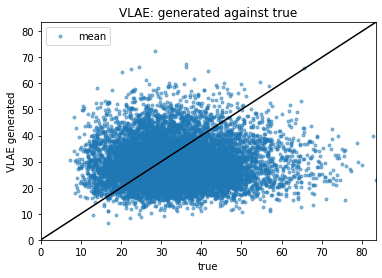

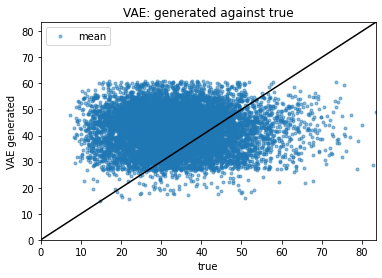

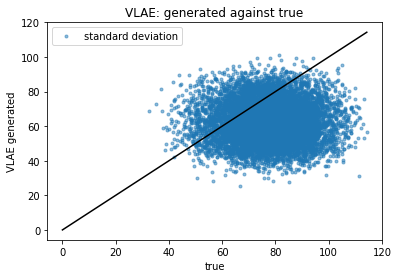

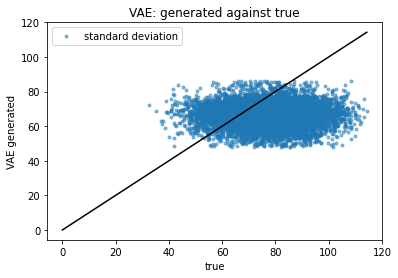

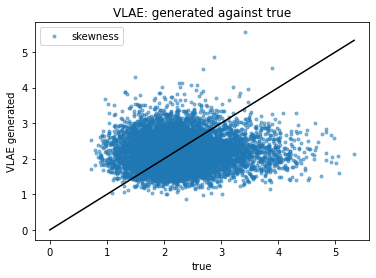

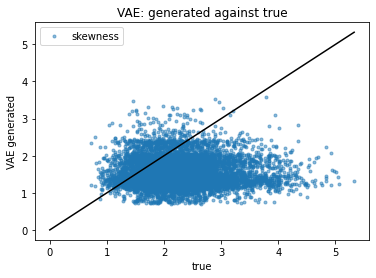

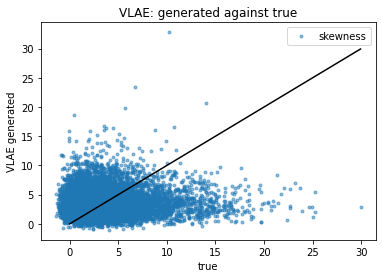

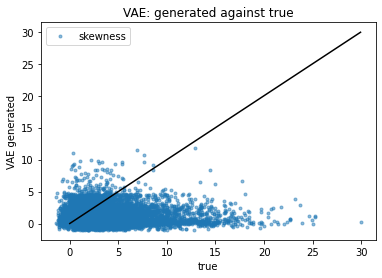

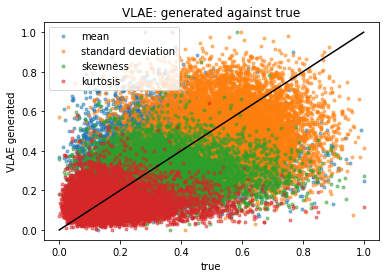

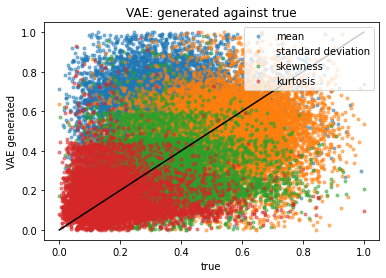

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

def _clamp(x):
    return (x - x.min())/(x.max() - x.min())

x = np.array([1, 2, 3, 4, 5])
y = np.power(x, 2) # Effectively y = x**2
maxx = max([mnist_mean.max(), mnist_sd.max(), vlae_gens_mean.max(), vlae_gens_sd.max()])

plt.plot((mnist_mean), (vlae_gens_mean), '.', label='mean', alpha=0.5)
mmax = max(mnist_mean.max(),vlae_gens_mean.max())
plt.plot([0.0, mmax], [0.0, mmax], c='k')
plt.xlim(0, mmax)
plt.ylim(0, mmax)
plt.legend()
plt.title('VLAE: generated against true')
plt.xlabel("true")
plt.ylabel("VLAE generated")
#plt.plot(e, mnist_mean, 'gx')
plt.show()
plt.close()

plt.plot((mnist_mean), (vae_gens_mean), '.', label='mean', alpha=0.5)
mmax = max(mnist_mean.max(),vae_gens_mean.max())
plt.plot([0.0, mmax], [0.0, mmax], c='k')
plt.xlim(0, mmax)
plt.ylim(0, mmax)
plt.legend()
plt.title('VAE: generated against true')
plt.xlabel("true")
plt.ylabel("VAE generated")
#plt.plot(e, mnist_mean, 'gx')
plt.show()
plt.close()

plt.plot((mnist_sd), (vlae_gens_sd), '.', label='standard deviation', alpha=0.5)
plt.plot([0.0, mnist_sd.max()], [0.0, mnist_sd.max()], c='k')
plt.legend()
plt.title('VLAE: generated against true')
plt.xlabel("true")
plt.ylabel("VLAE generated")
#plt.plot(e, mnist_mean, 'gx')
plt.show()
plt.close()

plt.plot((mnist_sd), (vae_gens_sd), '.', label='standard deviation', alpha=0.5)
plt.plot([0.0, mnist_sd.max()], [0.0, mnist_sd.max()], c='k')
plt.legend()
plt.title('VAE: generated against true')
plt.xlabel("true")
plt.ylabel("VAE generated")
#plt.plot(e, mnist_mean, 'gx')
plt.show()
plt.close()

plt.plot((mnist_skew), (vlae_gens_skew), '.', label="skewness", alpha=0.5)
plt.plot([0.0, mnist_skew.max()], [0.0, mnist_skew.max()], c='k')
plt.legend()
plt.title('VLAE: generated against true')
plt.xlabel("true")
plt.ylabel("VLAE generated")
#plt.plot(e, mnist_mean, 'gx')
plt.show()
plt.close()

plt.plot((mnist_skew), (vae_gens_skew), '.', label="skewness", alpha=0.5)
plt.plot([0.0, mnist_skew.max()], [0.0, mnist_skew.max()], c='k')
plt.legend()
plt.title('VAE: generated against true')
plt.xlabel("true")
plt.ylabel("VAE generated")
#plt.plot(e, mnist_mean, 'gx')
plt.show()
plt.close()

plt.plot((mnist_kurt), (vlae_gens_kurt), '.', label="skewness", alpha=0.5)
plt.plot([0.0, mnist_kurt.max()], [0.0, mnist_kurt.max()], c='k')
plt.legend()
plt.title('VLAE: generated against true')
plt.xlabel("true")
plt.ylabel("VLAE generated")
#plt.plot(e, mnist_mean, 'gx')
plt.show()
plt.close()

plt.plot((mnist_kurt), (vae_gens_kurt), '.', label="skewness", alpha=0.5)
plt.plot([0.0, mnist_kurt.max()], [0.0, mnist_kurt.max()], c='k')
plt.legend()
plt.title('VAE: generated against true')
plt.xlabel("true")
plt.ylabel("VAE generated")
#plt.plot(e, mnist_mean, 'gx')
plt.show()
plt.close()

plt.plot(_clamp(mnist_mean), _clamp(vlae_gens_mean), '.', label='mean', alpha=0.5)
plt.plot(_clamp(mnist_sd), _clamp(vlae_gens_sd), '.', label="standard deviation", alpha=0.5)
plt.plot(_clamp(mnist_skew), _clamp(vlae_gens_skew), '.', label="skewness", alpha=0.5)
plt.plot(_clamp(mnist_kurt), _clamp(vlae_gens_kurt), '.', label="kurtosis", alpha=0.5)
plt.plot([0.0, 1.0], [0.0, 1.0], c='k')

plt.legend()
plt.title('VLAE: generated against true')
plt.xlabel("true")
plt.ylabel("VLAE generated")
#plt.plot(e, mnist_mean, 'gx')
plt.show()
plt.close()

plt.plot(_clamp(mnist_mean), _clamp(vae_gens_mean), '.', label='mean', alpha=0.5)
plt.plot(_clamp(mnist_sd), _clamp(vae_gens_sd), '.', label="standard deviation", alpha=0.5)
plt.plot(_clamp(mnist_skew), _clamp(vae_gens_skew), '.', label="skewness", alpha=0.5)
plt.plot(_clamp(mnist_kurt), _clamp(vae_gens_kurt), '.', label="kurtosis", alpha=0.5)
plt.plot([0.0, 1.0], [0.0, 1.0], c='k')

plt.legend()
plt.title('VAE: generated against true')
plt.xlabel("true")
plt.ylabel("VAE generated")
#plt.plot(e, mnist_mean, 'gx')
plt.show()
plt.close()

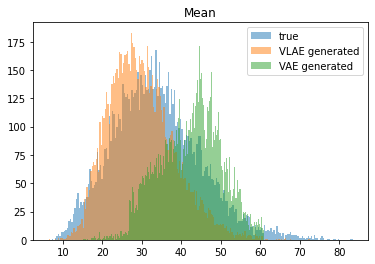

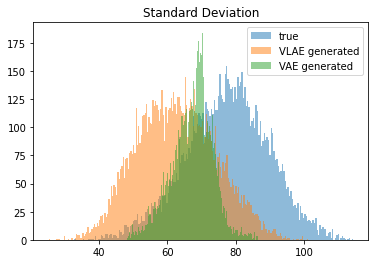

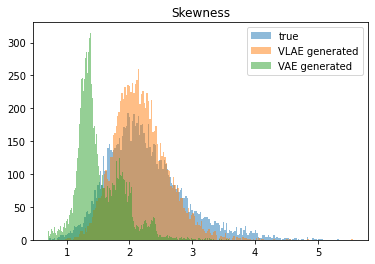

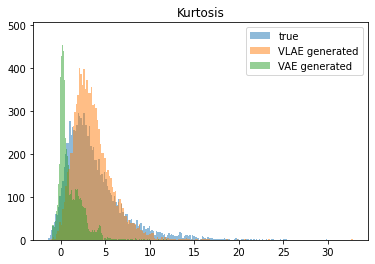

In [71]:
bins = 200
plt.title("Mean")
plt.hist(mnist_mean, bins, alpha=0.5, label="true")
plt.hist(vlae_gens_mean, bins, alpha=0.5, label="VLAE generated")
plt.hist(vae_gens_mean, bins, alpha=0.5, label="VAE generated")
plt.legend()
plt.show()
plt.close()
plt.title("Standard Deviation")
plt.hist(mnist_sd, bins, alpha=0.5, label="true")
plt.hist(vlae_gens_sd, bins, alpha=0.5, label="VLAE generated")
plt.hist(vae_gens_sd, bins, alpha=0.5, label="VAE generated")
plt.legend()
plt.show()
plt.close()
plt.title("Skewness")
plt.hist(mnist_skew, bins, alpha=0.5, label="true")
plt.hist(vlae_gens_skew, bins, alpha=0.5, label="VLAE generated")
plt.hist(vae_gens_skew, bins, alpha=0.5, label="VAE generated")
plt.legend()
plt.show()
plt.close()
plt.title("Kurtosis")
plt.hist(mnist_kurt, bins, alpha=0.5, label="true")
plt.hist(vlae_gens_kurt, bins, alpha=0.5, label="VLAE generated")
plt.hist(vae_gens_kurt, bins, alpha=0.5, label="VAE generated")
plt.legend()
plt.show()
plt.close()

In [73]:
from keras import Input, Model
from keras.layers import Conv2D, BatchNormalization, LeakyReLU, Flatten, Dense
from keras.datasets import mnist
import numpy as np

(x_train, _), (_, _) = mnist.load_data()
preds_train = vlae.decoder.predict([np.random.multivariate_normal([0.,0.], [[1.0, 0.0],[0.0, 1.0]], size=60000) for _ in range(3)]).squeeze()
x_train = np.concatenate([x_train, preds_train], axis=0)
x_train = np.expand_dims(x_train, axis=-1)
y_train = np.concatenate([np.zeros((60000)), np.ones((60000))])
x_train, y_train = shuffle(x_train, y_train)

x = inpt = Input(shape=(28,28,1))
x = Conv2D(batch_input_shape=(28,28,1), filters=20, kernel_size=5)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(filters=20, kernel_size=3)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(100)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = outpt = Dense(1, activation='sigmoid')(x)

model = Model(inpt, outpt)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.fit(x_train, y_train)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 20)        520       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 24, 24, 20)        0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 24, 24, 20)        80        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 20)        3620      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 22, 22, 20)        0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 22, 22, 20)        80        
__________

In [7]:
(_, _), (x_test, _) = mnist.load_data()
preds_test = vlae.decoder.predict([np.random.multivariate_normal([0.,0.], [[1.0, 0.0],[0.0, 1.0]], size=10000) for _ in range(3)]).squeeze()
x_test = np.concatenate([x_test, preds_test], axis=0)
x_test = np.expand_dims(x_test, axis=-1)
y_test = np.concatenate([np.zeros((10000)), np.ones((10000))])
x_test, y_test = shuffle(x_test, y_test)
# model.evaluate(x_test, y_test)



In [138]:
from models.model_abstract import ModelWrapper

def avg_gen_for_a(a: np.ndarray, num_zs: int, num_samples: int):

    def avg_gen_for_a_and_z(z_idx: int):
        zs = [np.expand_dims(np.random.multivariate_normal([0.,0.], [[1.0, 0.0],[0.0, 1.0]], size=num_samples), 0) for _ in range(num_zs)]
        zs[z_idx] = np.array([a for _ in range(num_samples)])
        zs[z_idx] = zs[z_idx].swapaxes(0,1)
        zs = np.concatenate(zs)
        gens = vlae.decoder.predict(list(zs)) * 255.0
        #gens = [vlae.decoder.predict([zs[j, i] for j in range(3)] for i in range(num_samples))]
        return np.mean(gens, axis=0)

    return np.array([avg_gen_for_a_and_z(z_idx) for z_idx in range(num_zs)])

num_as = 100
num_samples = 300
a_s = np.random.multivariate_normal([0.,0.], [[1.0, 0.0],[0.0, 1.0]], size=num_as)
gens = np.array([avg_gen_for_a(np.expand_dims(a,0), 3, num_samples) for a in a_s])

In [ ]:
from utils.statistic import cross_cumulants
import matplotlib
%matplotlib inline

for i in range(28):
    for j in range(28):
        pxl = gens[:,0,i,j,0]
        pxl = np.stack([pxl, pxl], axis=1)
        #print(cross_cumulants(pxl))
        
rows = 17
cols = 17
fig, ax = plt.subplots(nrows=rows,ncols=cols,sharex=True,sharey=True)
print(ax.shape)
k=0
for i in range(28):
    for j in range(28):
        g1 = np.copy(gens[:,0,i,j,0])
        g2 = np.copy(gens[:,1,i,j,0])
        if max(np.max(g1), np.max(g2))>200:
            #print(np.max(g1), np.max(g2))
            row = k//(rows-1)
            col = k%cols
            #print("k {} row {} col {}".format(k, row, col))
            ax[row,col].plot(g1,g2,'.')
            k+=1
            print(k)
fig.xlabel = "Mean pixel itensity first component"
fig.ylabel = "Mean pixel intensity second component"
fig.savefig("AGGRU.png")

#plt.plot(gens[:,0,14,14,0],gens[:,2,14,14,0],'.')
#plt.plot(gens[:,1,14,14,0],gens[:,2,14,14,0],'.')

(17, 17)


[ 1.78031577  0.8600826   1.79657585 ... 45.09885843 55.51393243
 46.54836231]


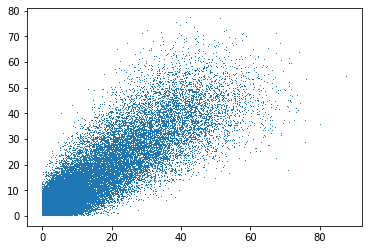

In [67]:
x = np.concatenate([np.random.chisquare(i, 10000//i) for i in range(1,50)])
y = np.concatenate([np.random.chisquare(i, 10000//i) for i in range(1,50)])
print(x)
plt.plot(x,y,',')